In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/randomnforest/test2.csv
/kaggle/input/randomnforest/train2.csv


# **Importing Libraries**


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC

In [3]:
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [5]:
from sklearn.ensemble import VotingClassifier

In [6]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC

# **Loading Data**


In [7]:
train_data = pd.read_csv("/kaggle/input/randomnforest/train2.csv")
test_data = pd.read_csv("/kaggle/input/randomnforest/test2.csv")

In [8]:
train_data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [9]:
segment_counts = train_data['Segmentation'].value_counts()

print("Counts of each segment:")
print(segment_counts)

Counts of each segment:
Segmentation
D    2268
A    1972
C    1970
B    1858
Name: count, dtype: int64


In [10]:
train_data.head(), train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


(       ID  Gender Ever_Married  Age Graduated     Profession  Work_Experience  \
 0  462809    Male           No   22        No     Healthcare              1.0   
 1  462643  Female          Yes   38       Yes       Engineer              NaN   
 2  466315  Female          Yes   67       Yes       Engineer              1.0   
 3  461735    Male          Yes   67       Yes         Lawyer              0.0   
 4  462669  Female          Yes   40       Yes  Entertainment              NaN   
 
   Spending_Score  Family_Size  Var_1 Segmentation  
 0            Low          4.0  Cat_4            D  
 1        Average          3.0  Cat_4            A  
 2            Low          1.0  Cat_6            B  
 3           High          2.0  Cat_6            B  
 4           High          6.0  Cat_6            A  ,
 None)

# **Handling Missing Values and Encoding Data**


In [11]:
for col in ['Work_Experience', 'Family_Size']:
    train_data[col] = train_data[col].fillna(train_data[col].median())
    test_data[col] = test_data[col].fillna(test_data[col].median())

In [12]:
for col in ['Ever_Married', 'Graduated', 'Profession', 'Var_1']:
    train_data[col] = train_data[col].fillna('Unknown')
    test_data[col] = test_data[col].fillna('Unknown')

In [13]:
label_encoders = {}
categorical_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.transform(test_data[col])  
    label_encoders[col] = le

In [14]:
target_encoder = LabelEncoder()
train_data['Segmentation'] = target_encoder.fit_transform(train_data['Segmentation'])

# **Correlation of All Columns Against Segmentation Column**


In [15]:
correlation_matrix = train_data.corr()

target_correlation = correlation_matrix['Segmentation'].sort_values(ascending=False)
print("Correlation with Segmentation column:")
print(target_correlation)

from scipy.stats import pointbiserialr

categorical_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']

for col in categorical_cols:
    correlation, _ = pointbiserialr(train_data[col], train_data['Segmentation'])
    print(f"Point biserial correlation between {col} and Segmentation: {correlation:.2f}")


Correlation with Segmentation column:
Segmentation       1.000000
Profession         0.202419
Family_Size        0.191476
Spending_Score     0.100572
Gender             0.026403
Work_Experience    0.008216
ID                -0.009104
Var_1             -0.017233
Graduated         -0.177932
Ever_Married      -0.216577
Age               -0.243552
Name: Segmentation, dtype: float64
Point biserial correlation between Gender and Segmentation: 0.03
Point biserial correlation between Ever_Married and Segmentation: -0.22
Point biserial correlation between Graduated and Segmentation: -0.18
Point biserial correlation between Profession and Segmentation: 0.20
Point biserial correlation between Spending_Score and Segmentation: 0.10
Point biserial correlation between Var_1 and Segmentation: -0.02


In [16]:
train_data.drop('ID', axis=1, inplace=True)
test_ids = test_data['ID'] 
test_data.drop('ID', axis=1, inplace=True)

# **Splitting the Train Data into train_data1 (2 and 3), train_data2 (0 and 1)**


In [17]:
train_data1 = train_data[train_data['Segmentation'].isin([2, 3])]

In [18]:
train_data1.shape

(4238, 10)

In [19]:
train_data2 = train_data[train_data['Segmentation'].isin([0, 1])]

In [20]:
train_data2.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
1,0,2,38,2,2,1.0,0,3.0,3,0
2,0,2,67,2,2,1.0,2,1.0,5,1
3,1,2,67,2,7,0.0,1,2.0,5,1
4,0,2,40,2,3,1.0,1,6.0,5,0
10,0,0,26,2,2,1.0,2,3.0,5,0


In [21]:
train_data2.shape

(3830, 10)

In [22]:
train_data1.shape

(4238, 10)

# **Random Forest on train_data1 (2 and 3)**


In [23]:
X1 = train_data1.drop('Segmentation', axis=1)
y1 = train_data1['Segmentation']


In [24]:
X_train1, X_val1, y_train1, y_val1 = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)

In [25]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train1, y_train1)

RandomForestClassifier(random_state=42)

In [26]:
y_val_pred1 = rf_model.predict(X_val1)
print("Validation Accuracy:", accuracy_score(y_val1, y_val_pred1))
print("\nClassification Report:\n", classification_report(y_val1, y_val_pred1))

Validation Accuracy: 0.8372641509433962

Classification Report:
               precision    recall  f1-score   support

           2       0.84      0.80      0.82       394
           3       0.83      0.87      0.85       454

    accuracy                           0.84       848
   macro avg       0.84      0.83      0.84       848
weighted avg       0.84      0.84      0.84       848



# **Random Forest on train_data2 (0 and 1)**


In [27]:
X2 = train_data2.drop('Segmentation', axis=1)
y2 = train_data2['Segmentation']

In [28]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)

In [29]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train2, y_train2)

RandomForestClassifier(random_state=42)

In [30]:
y_val_pred2 = rf_model.predict(X_val2)
print("Validation Accuracy:", accuracy_score(y_val2, y_val_pred2))
print("\nClassification Report:\n", classification_report(y_val2, y_val_pred2))

Validation Accuracy: 0.639686684073107

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.66      0.65       394
           1       0.63      0.62      0.62       372

    accuracy                           0.64       766
   macro avg       0.64      0.64      0.64       766
weighted avg       0.64      0.64      0.64       766



# **Analyzing train_data2 (0 and 1) and train_data1 (2 and 3) because of variation in accuracy of train_data1 and train_data2**


Correlation with Segmentation column:
Segmentation       1.000000
Ever_Married       0.158040
Graduated          0.104410
Age                0.104048
Family_Size        0.083126
Var_1              0.023254
Gender            -0.002454
Work_Experience   -0.068958
Profession        -0.084773
Spending_Score    -0.211110
Name: Segmentation, dtype: float64


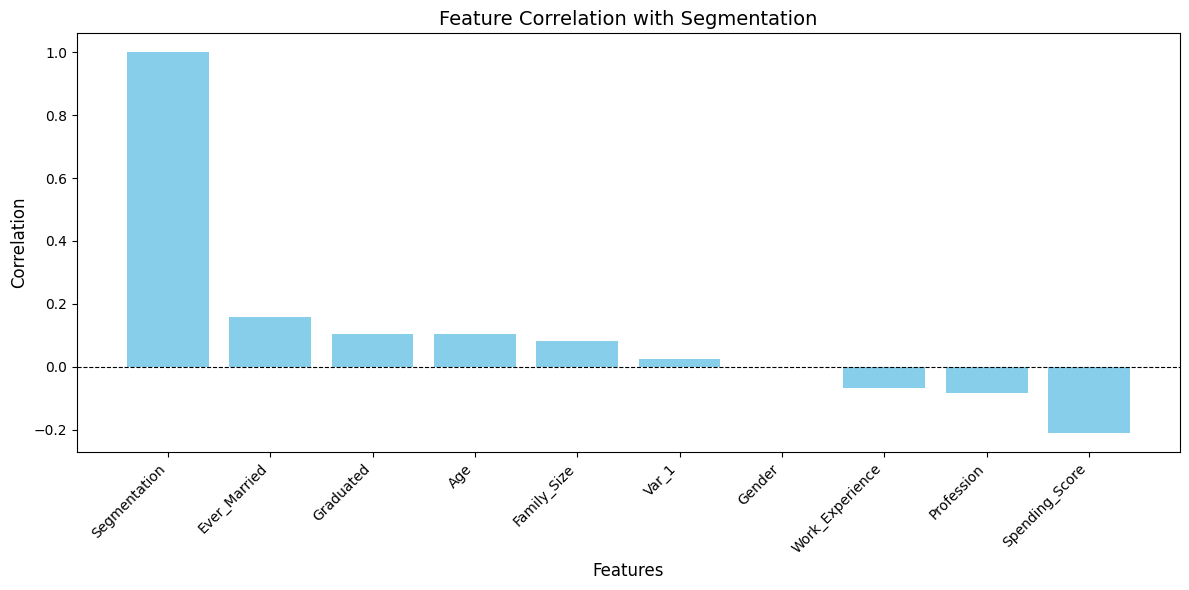

In [92]:
import matplotlib.pyplot as plt
import pandas as pd

correlation_matrix = train_data2.corr()
target_correlation = correlation_matrix['Segmentation'].sort_values(ascending=False)
print("Correlation with Segmentation column:")
print(target_correlation)

from scipy.stats import pointbiserialr

categorical_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
categorical_correlations = {}
for col in categorical_cols:
    correlation, _ = pointbiserialr(train_data2[col], train_data2['Segmentation'])
    categorical_correlations[col] = correlation

combined_correlation = pd.DataFrame({
    'Feature': list(target_correlation.index) + list(categorical_correlations.keys()),
    'Correlation': list(target_correlation.values) + list(categorical_correlations.values())
})

plt.figure(figsize=(12, 6))
plt.bar(combined_correlation['Feature'], combined_correlation['Correlation'], color='skyblue')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('Feature Correlation with Segmentation', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

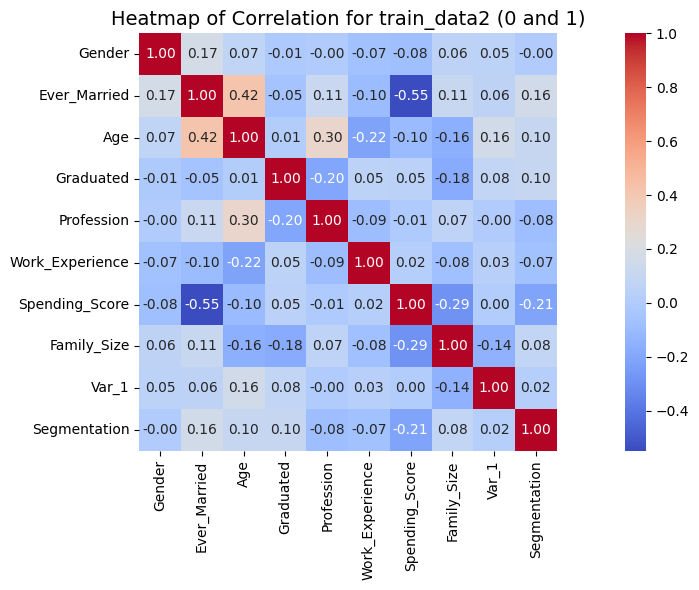

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr

numerical_correlation_matrix = train_data2.corr()
categorical_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
categorical_correlations = {}
for col in categorical_cols:
    correlation, _ = pointbiserialr(train_data2[col], train_data2['Segmentation'])
    categorical_correlations[col] = correlation

categorical_correlation_df = pd.DataFrame.from_dict(categorical_correlations, orient='index', columns=['Segmentation'])
combined_correlation_matrix = numerical_correlation_matrix.copy()
for col in categorical_cols:
    combined_correlation_matrix.loc[col, 'Segmentation'] = categorical_correlation_df.loc[col, 'Segmentation']

combined_correlation_matrix = combined_correlation_matrix.fillna(0)

plt.figure(figsize=(14, 6))
sns.heatmap(combined_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Heatmap of Correlation for train_data2 (0 and 1)', fontsize=14)
plt.tight_layout()
plt.show()


Correlation with Segmentation column:
Segmentation       1.000000
Spending_Score     0.545483
Profession         0.453977
Work_Experience    0.095752
Family_Size        0.079372
Gender             0.045356
Var_1             -0.152141
Age               -0.459856
Graduated         -0.463821
Ever_Married      -0.515806
Name: Segmentation, dtype: float64


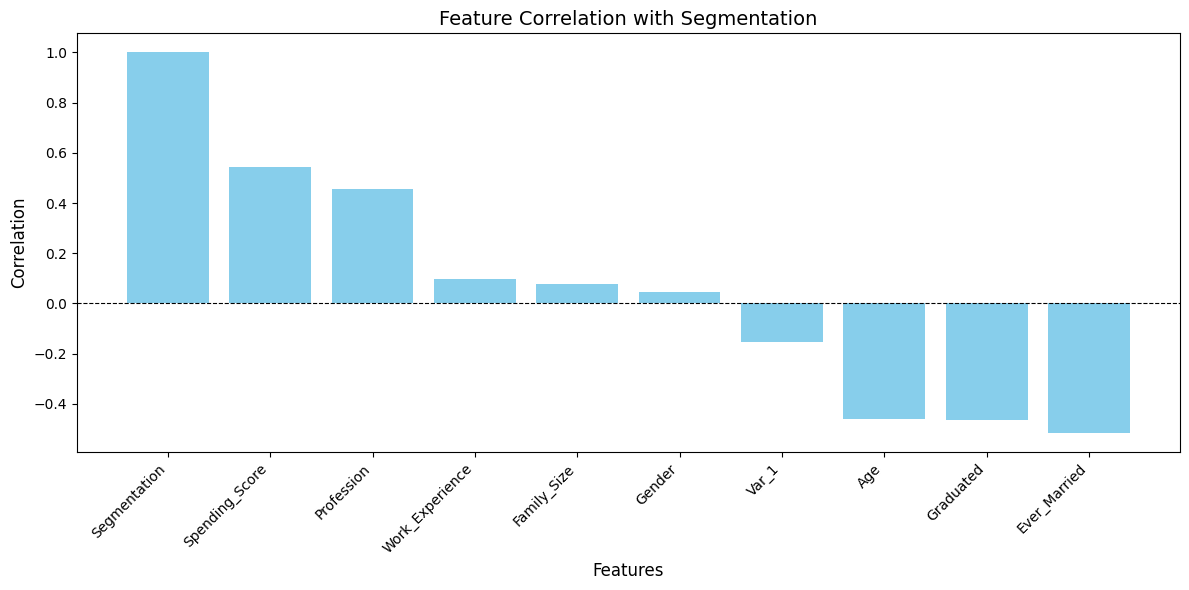

In [91]:
import matplotlib.pyplot as plt
import pandas as pd

correlation_matrix = train_data1.corr()
target_correlation = correlation_matrix['Segmentation'].sort_values(ascending=False)
print("Correlation with Segmentation column:")
print(target_correlation)

from scipy.stats import pointbiserialr

categorical_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
categorical_correlations = {}
for col in categorical_cols:
    correlation, _ = pointbiserialr(train_data1[col], train_data1['Segmentation'])
    categorical_correlations[col] = correlation

combined_correlation = pd.DataFrame({
    'Feature': list(target_correlation.index) + list(categorical_correlations.keys()),
    'Correlation': list(target_correlation.values) + list(categorical_correlations.values())
})

plt.figure(figsize=(12, 6))
plt.bar(combined_correlation['Feature'], combined_correlation['Correlation'], color='skyblue')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('Feature Correlation with Segmentation', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


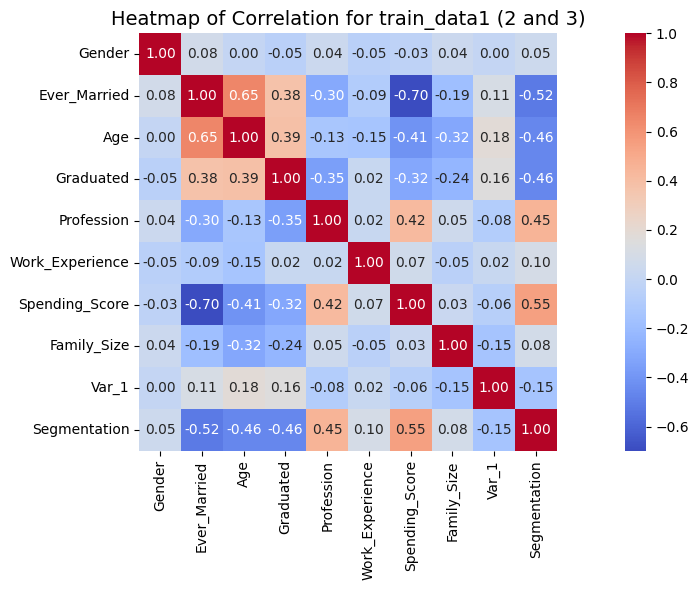

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr

numerical_correlation_matrix = train_data1.corr()
categorical_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
categorical_correlations = {}
for col in categorical_cols:
    correlation, _ = pointbiserialr(train_data1[col], train_data1['Segmentation'])
    categorical_correlations[col] = correlation

categorical_correlation_df = pd.DataFrame.from_dict(categorical_correlations, orient='index', columns=['Segmentation'])
combined_correlation_matrix = numerical_correlation_matrix.copy()
for col in categorical_cols:
    combined_correlation_matrix.loc[col, 'Segmentation'] = categorical_correlation_df.loc[col, 'Segmentation']

combined_correlation_matrix = combined_correlation_matrix.fillna(0)

plt.figure(figsize=(14, 6))
sns.heatmap(combined_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Heatmap of Correlation for train_data1 (2 and 3)', fontsize=14)
plt.tight_layout()
plt.show()


In [33]:
age_counts = train_data1['Graduated'].value_counts()
print(age_counts)

Graduated
2    2417
0    1785
1      36
Name: count, dtype: int64


In [34]:
age_counts = train_data2['Graduated'].value_counts()
print(age_counts)

Graduated
2    2551
0    1237
1      42
Name: count, dtype: int64


In [35]:
age_counts = train_data1['Ever_Married'].value_counts()
print(age_counts)

Ever_Married
2    2158
0    2005
1      75
Name: count, dtype: int64


In [36]:
age_counts = train_data2['Ever_Married'].value_counts()
print(age_counts)

Ever_Married
2    2485
0    1280
1      65
Name: count, dtype: int64


In [37]:
data = pd.read_csv("/kaggle/input/randomnforest/train2.csv")

In [38]:
age_counts = data['Ever_Married'].value_counts()
print(age_counts)

Ever_Married
Yes    4643
No     3285
Name: count, dtype: int64


In [39]:
age_counts = data['Graduated'].value_counts()
print(age_counts)

Graduated
Yes    4968
No     3022
Name: count, dtype: int64


In [40]:
data = data.dropna(subset=['Ever_Married', 'Graduated'])

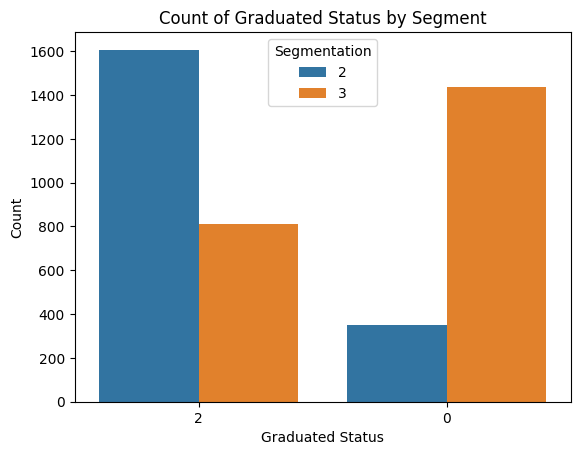

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=train_data1, x='Graduated', hue='Segmentation', order=[2, 0])
plt.title('Count of Graduated Status by Segment')
plt.xlabel('Graduated Status')
plt.ylabel('Count')
plt.show()


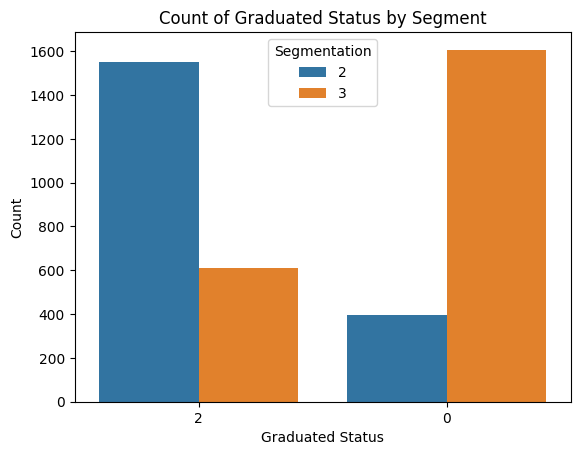

In [42]:

sns.countplot(data=train_data1, x='Ever_Married', hue='Segmentation', order=[2, 0])
plt.title('Count of Graduated Status by Segment')
plt.xlabel('Graduated Status')
plt.ylabel('Count')
plt.show()

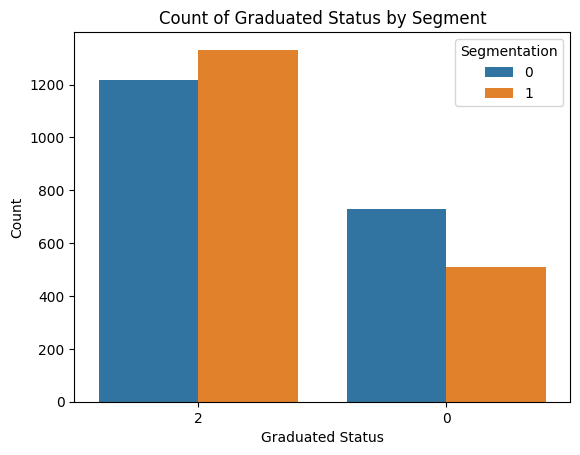

In [43]:
sns.countplot(data=train_data2, x='Graduated', hue='Segmentation', order=[2, 0])
plt.title('Count of Graduated Status by Segment')
plt.xlabel('Graduated Status')
plt.ylabel('Count')
plt.show()

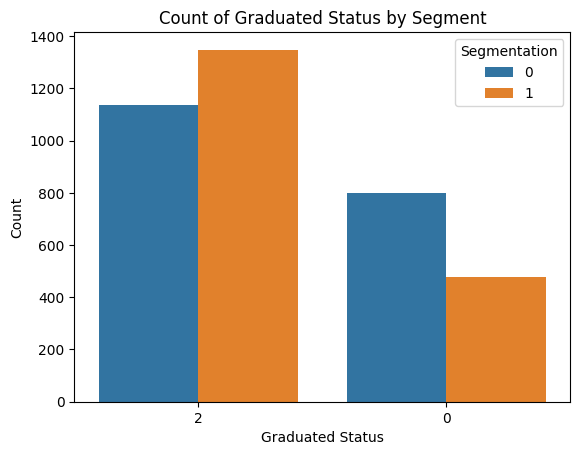

In [44]:
sns.countplot(data=train_data2, x='Ever_Married', hue='Segmentation', order=[2, 0])
plt.title('Count of Graduated Status by Segment')
plt.xlabel('Graduated Status')
plt.ylabel('Count')
plt.show()

# **Generating samples for train_data1 (0 and 1) and also we will focus on train_data1 (0 and 1)**


In [45]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X2, y2)

# **LightGBM Classifier**


In [46]:
X_train3, X_val3, y_train3, y_val3 = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [47]:
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_train3, y_train3)

[LightGBM] [Info] Number of positive: 1578, number of negative: 1577
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 146
[LightGBM] [Info] Number of data points in the train set: 3155, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500158 -> initscore=0.000634
[LightGBM] [Info] Start training from score 0.000634


LGBMClassifier(random_state=42)

In [48]:
y_val_pred3 = lgb_model.predict(X_val3)
print("Validation Accuracy:", accuracy_score(y_val3, y_val_pred3))
print("\nClassification Report:\n", classification_report(y_val3, y_val_pred3))

Validation Accuracy: 0.6514575411913816

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.65      0.65       395
           1       0.65      0.65      0.65       394

    accuracy                           0.65       789
   macro avg       0.65      0.65      0.65       789
weighted avg       0.65      0.65      0.65       789



           Feature  Importance
2              Age        1083
5  Work_Experience         388
4       Profession         373
7      Family_Size         350
8            Var_1         268
3        Graduated         147
0           Gender         134
1     Ever_Married         133
6   Spending_Score         124


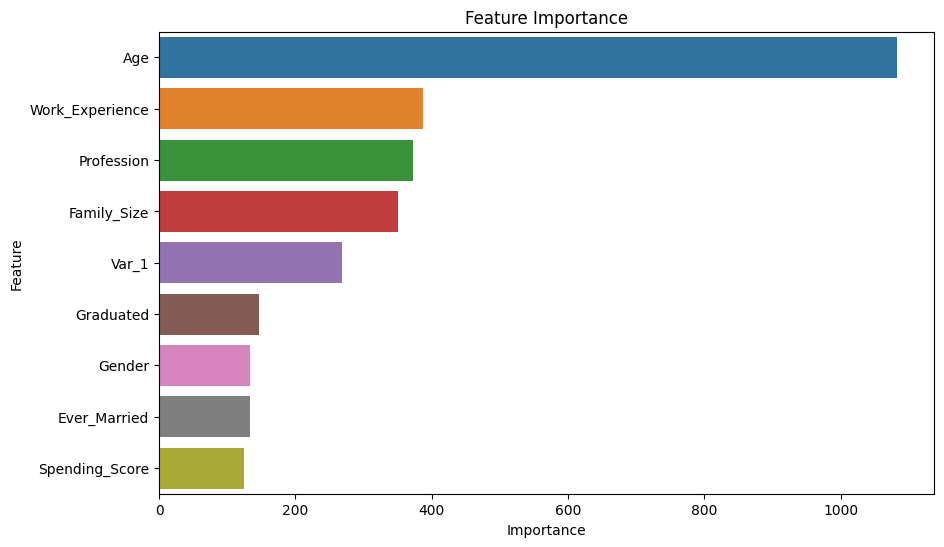

In [49]:
feature_importance = lgb_model.feature_importances_
features = X2.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)
print(importance_df)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

In [111]:
X_resampled1, y_resampled1 = smote.fit_resample(X1, y1)

In [112]:
X_train4, X_val4, y_train4, y_val4 = train_test_split(X_resampled1, y_resampled1, test_size=0.2, random_state=42, stratify=y_resampled1)

In [113]:
lgb_model1 = LGBMClassifier(random_state=42)
lgb_model1.fit(X_train4, y_train4)

[LightGBM] [Info] Number of positive: 1814, number of negative: 1814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 3628, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(random_state=42)

In [114]:
y_val_pred4 = lgb_model1.predict(X_val4)
print("Validation Accuracy:", accuracy_score(y_val4, y_val_pred4))
print("\nClassification Report:\n", classification_report(y_val4, y_val_pred4))

Validation Accuracy: 0.8436123348017621

Classification Report:
               precision    recall  f1-score   support

           2       0.86      0.81      0.84       454
           3       0.82      0.87      0.85       454

    accuracy                           0.84       908
   macro avg       0.84      0.84      0.84       908
weighted avg       0.84      0.84      0.84       908



           Feature  Importance
2              Age         950
4       Profession         458
5  Work_Experience         393
7      Family_Size         383
8            Var_1         297
0           Gender         161
3        Graduated         143
6   Spending_Score         134
1     Ever_Married          81


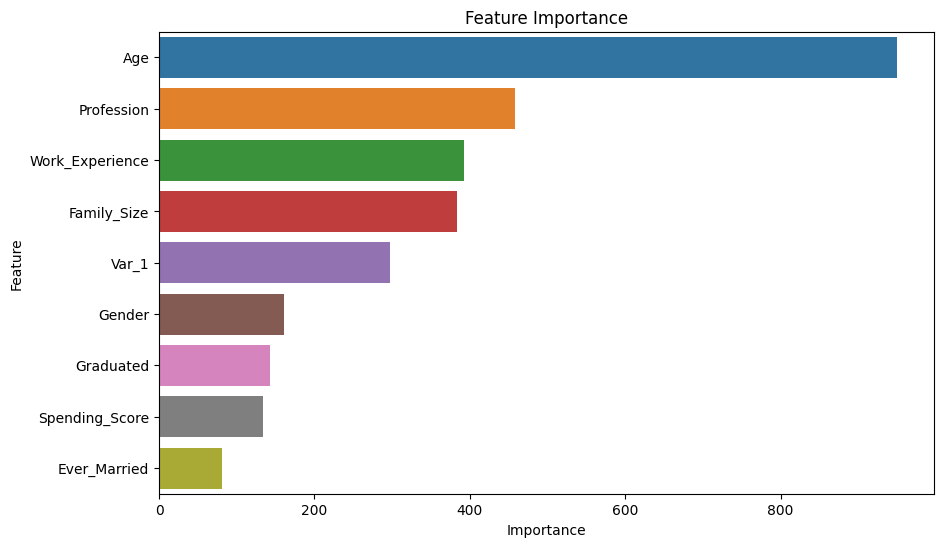

In [116]:
feature_importance = lgb_model1.feature_importances_
features = X1.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)
print(importance_df)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

In [55]:
X3 = X2

In [56]:
y3 = y2

In [57]:
X3.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
1,0,2,38,2,2,1.0,0,3.0,3
2,0,2,67,2,2,1.0,2,1.0,5
3,1,2,67,2,7,0.0,1,2.0,5
4,0,2,40,2,3,1.0,1,6.0,5
10,0,0,26,2,2,1.0,2,3.0,5


In [58]:
y3.head()

1     0
2     1
3     1
4     0
10    0
Name: Segmentation, dtype: int64

In [59]:
numerical_cols = ['Age', 'Work_Experience', 'Family_Size']
scaler = StandardScaler()
X3[numerical_cols] = scaler.fit_transform(X3[numerical_cols])

# **GaussianNB Classifier**


In [60]:
X_train5, X_val5, y_train5, y_val5 = train_test_split(X3, y3, test_size=0.2, random_state=42)

model = GaussianNB()
model.fit(X_train5, y_train5)

GaussianNB()

In [61]:
y_pred5 = model.predict(X_val5)

accuracy = accuracy_score(y_val5, y_pred5)
print("Validation Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_val5, y_pred5))
print("\nConfusion Matrix:\n", confusion_matrix(y_val5, y_pred5))

Validation Accuracy: 0.6409921671018277

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.68      0.65       385
           1       0.65      0.61      0.63       381

    accuracy                           0.64       766
   macro avg       0.64      0.64      0.64       766
weighted avg       0.64      0.64      0.64       766


Confusion Matrix:
 [[260 125]
 [150 231]]


# **Logistic Regression on train_data2 (0 and 1)**


In [62]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
model.fit(X_train5, y_train5)

y_pred5 = model.predict(X_val5)

accuracy = accuracy_score(y_val5, y_pred5)
print("Validation Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_val5, y_pred5))
print("\nConfusion Matrix:\n", confusion_matrix(y_val5, y_pred5))

Validation Accuracy: 0.6357702349869452

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.72      0.67       385
           1       0.66      0.55      0.60       381

    accuracy                           0.64       766
   macro avg       0.64      0.64      0.63       766
weighted avg       0.64      0.64      0.63       766


Confusion Matrix:
 [[277 108]
 [171 210]]


# **XGBoost Classifier on train_data2 (0 and 1)**


In [63]:
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(y3.unique()),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
xgb_model.fit(X_train5, y_train5)

y_pred5 = xgb_model.predict(X_val5)

accuracy = accuracy_score(y_val5, y_pred5)
print("Validation Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_val5, y_pred5))
print("\nConfusion Matrix:\n", confusion_matrix(y_val5, y_pred5))

Validation Accuracy: 0.6044386422976501

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.63      0.62       385
           1       0.61      0.58      0.59       381

    accuracy                           0.60       766
   macro avg       0.60      0.60      0.60       766
weighted avg       0.60      0.60      0.60       766


Confusion Matrix:
 [[243 142]
 [161 220]]


# **KNN on train_data2 (0 and 1)**


In [64]:
knn_model = KNeighborsClassifier(n_neighbors=40, weights='distance')  # You can tune 'n_neighbors'
knn_model.fit(X_train5, y_train5)


y_pred5 = knn_model.predict(X_val5)

accuracy = accuracy_score(y_val5, y_pred5)
print("Validation Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_val5, y_pred5))
print("\nConfusion Matrix:\n", confusion_matrix(y_val5, y_pred5))

Validation Accuracy: 0.6631853785900783

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.65      0.66       385
           1       0.66      0.67      0.67       381

    accuracy                           0.66       766
   macro avg       0.66      0.66      0.66       766
weighted avg       0.66      0.66      0.66       766


Confusion Matrix:
 [[251 134]
 [124 257]]


# **Neural Network on train_data2 (0 and 1)**


In [65]:
model = Sequential()
model.add(Dense(64, input_dim=X_train5.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train5, y_train5, epochs=50, batch_size=32, validation_data=(X_val5, y_val5))

y_pred5 = (model.predict(X_val5) > 0.5).astype(int)
accuracy = accuracy_score(y_val5, y_pred5)
print(f"Validation Accuracy: {accuracy}")

print(classification_report(y_val5, y_pred5))

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5656 - loss: 0.6847 - val_accuracy: 0.6214 - val_loss: 0.6475
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6398 - loss: 0.6387 - val_accuracy: 0.6371 - val_loss: 0.6376
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6313 - loss: 0.6415 - val_accuracy: 0.6619 - val_loss: 0.6317
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6403 - loss: 0.6326 - val_accuracy: 0.6475 - val_loss: 0.6355
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6317 - loss: 0.6367 - val_accuracy: 0.6684 - val_loss: 0.6297
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6485 - loss: 0.6314 - val_accuracy: 0.6201 - val_loss: 0.6530
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6575 - loss: 0.6223 - val_accuracy: 0.6475 - val_loss: 0.6374
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6570 - loss: 0.6239 - val_accuracy: 0.6436 - val_loss: 0.6338
Epo

# **Ensemble Learning on train_data2 (0 and 1)**


In [66]:
logreg2 = LogisticRegression(max_iter=1000, random_state=42)
knn2 = KNeighborsClassifier(n_neighbors=40, weights='distance')
xgb2 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
rf2 = RandomForestClassifier(n_estimators=100, random_state=42)

ensemble_model = VotingClassifier(estimators=[
    ('logreg', logreg2),
    ('knn', knn2),
    ('xgb', xgb2),
    ('rf', rf2)
], voting='hard') 

ensemble_model.fit(X_train5, y_train5)

validation_accuracy = ensemble_model.score(X_val5, y_val5)
print(f'Validation Accuracy of Ensemble Model: {validation_accuracy:.2f}')

Validation Accuracy of Ensemble Model: 0.65


In [67]:
base_models = [
    ('logreg', logreg2),
    ('knn', knn2),
    ('xgb', xgb2),
    ('rf', rf2)
]
meta_model = SVC(probability=True, random_state=42)
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)
stacking_model.fit(X_train5, y_train5)

validation_accuracy_stacking = stacking_model.score(X_val5, y_val5)
print(f'Validation Accuracy of Stacking Model: {validation_accuracy_stacking:.2f}')

Validation Accuracy of Stacking Model: 0.65


# **Feature Engineering**


In [68]:
train_data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3830 entries, 1 to 8067
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           3830 non-null   int64  
 1   Ever_Married     3830 non-null   int64  
 2   Age              3830 non-null   int64  
 3   Graduated        3830 non-null   int64  
 4   Profession       3830 non-null   int64  
 5   Work_Experience  3830 non-null   float64
 6   Spending_Score   3830 non-null   int64  
 7   Family_Size      3830 non-null   float64
 8   Var_1            3830 non-null   int64  
 9   Segmentation     3830 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 329.1 KB


In [69]:
print(train_data2.columns)

Index(['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')


In [70]:
print(train_data2.dtypes)

Gender               int64
Ever_Married         int64
Age                  int64
Graduated            int64
Profession           int64
Work_Experience    float64
Spending_Score       int64
Family_Size        float64
Var_1                int64
Segmentation         int64
dtype: object


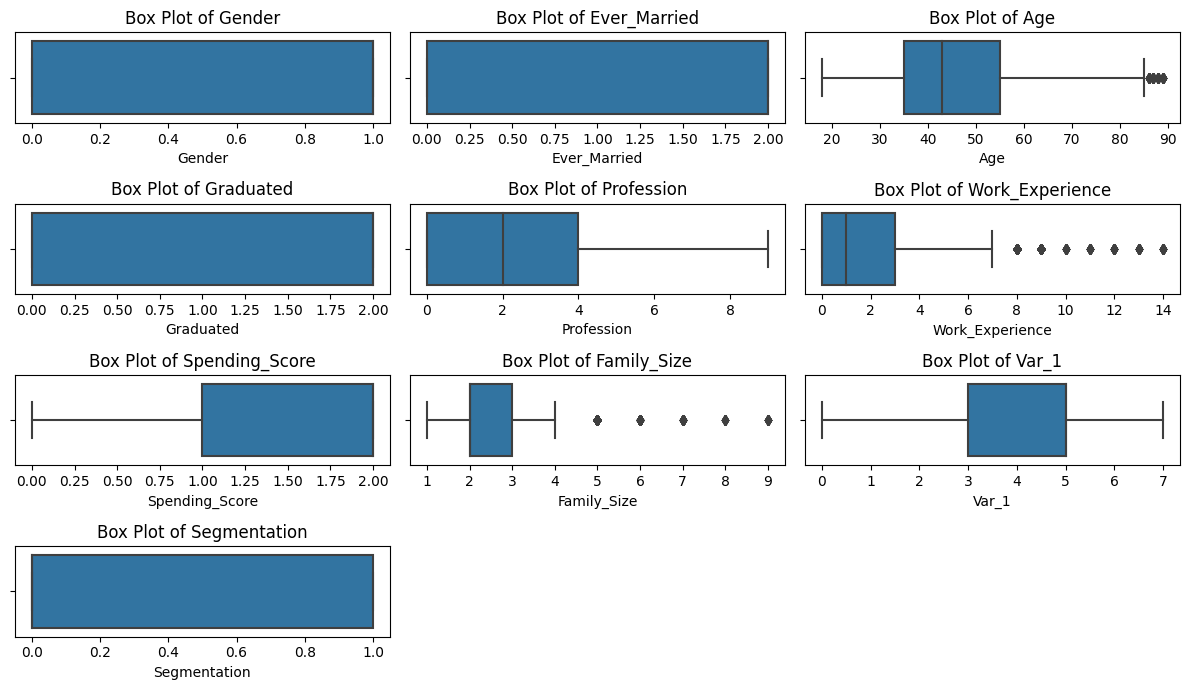

In [75]:
plt.figure(figsize=(12, 7))
for i, col in enumerate(train_data2.columns):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(data=train_data2, x=col)
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

In [117]:

def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

outliers_dict = {}
for col in train_data2.columns:
    if train_data2[col].dtype in ['int64', 'float64']: 
        outliers = detect_outliers(train_data2, col)
        if not outliers.empty:
            outliers_dict[col] = outliers.shape[0] 

for col, count in outliers_dict.items():
    print(f'Column: {col}, Number of outliers: {count}')


Column: Age, Number of outliers: 76
Column: Work_Experience, Number of outliers: 556
Column: Family_Size, Number of outliers: 359


In [78]:
train_data2_fe = train_data2.copy()
train_data2_fe['Work_Experience'] = np.where(train_data2_fe['Work_Experience'] > 0, np.log(train_data2_fe['Work_Experience'] + 1), 0)
train_data2_fe['Spending_Score'] = np.where(train_data2_fe['Spending_Score'] > 0, np.log(train_data2_fe['Spending_Score'] + 1), 0)

bins = [0, 18, 25, 35, 45, 55, 65, 75, 100]
age_labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-100']
train_data2_fe['Age_Bin'] = pd.cut(train_data2_fe['Age'], bins=bins, labels=age_labels)

work_exp_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]
work_exp_labels = ['0-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-35', '36-40']
train_data2_fe['Work_Exp_Bin'] = pd.cut(train_data2_fe['Work_Experience'], bins=work_exp_bins, labels=work_exp_labels)

spending_score_bins = [0, 20, 40, 60, 80, 100]
spending_score_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
train_data2_fe['Spending_Score_Category'] = pd.cut(train_data2_fe['Spending_Score'], bins=spending_score_bins, labels=spending_score_labels)

label_encoder = LabelEncoder()
train_data2_fe['Age_Bin'] = label_encoder.fit_transform(train_data2_fe['Age_Bin'])
train_data2_fe['Work_Exp_Bin'] = label_encoder.fit_transform(train_data2_fe['Work_Exp_Bin'])
train_data2_fe['Spending_Score_Category'] = label_encoder.fit_transform(train_data2_fe['Spending_Score_Category'])

train_data2_fe['Age_Work_Experience'] = train_data2_fe['Age'] * train_data2_fe['Work_Experience']
train_data2_fe['Age_Spending_Score'] = train_data2_fe['Age'] * train_data2_fe['Spending_Score']

scaler = StandardScaler()
numerical_features = ['Age', 'Work_Experience', 'Family_Size', 'Spending_Score']
train_data2_fe[numerical_features] = scaler.fit_transform(train_data2_fe[numerical_features])


In [79]:
train_data2_fe.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Age_Bin,Work_Exp_Bin,Spending_Score_Category,Age_Work_Experience,Age_Spending_Score
1,0,2,-0.541171,2,2,-0.236799,-1.667672,0.292989,3,0,3,0,1,26.339593,0.000000
2,0,2,1.302175,2,2,-0.236799,0.737812,-1.107944,5,1,6,0,0,46.440861,73.607023
3,1,2,1.302175,2,7,-1.096715,-0.149980,-0.407478,5,1,6,1,0,0.000000,46.440861
4,0,2,-0.414043,2,3,-0.236799,-0.149980,2.394388,5,0,3,0,0,27.725887,27.725887
10,0,0,-1.303934,2,2,-0.236799,0.737812,0.292989,5,0,2,0,0,18.021827,28.563920


In [80]:

correlation_with_segment = train_data2_fe.corr()['Segmentation'].sort_values(ascending=False)

print("Correlation with Segmentation column:")
print(correlation_with_segment)


Correlation with Segmentation column:
Segmentation               1.000000
Spending_Score_Category    0.167204
Ever_Married               0.158040
Age_Bin                    0.114192
Graduated                  0.104410
Age                        0.104048
Family_Size                0.083126
Work_Exp_Bin               0.028139
Var_1                      0.023254
Gender                    -0.002454
Age_Work_Experience       -0.021085
Work_Experience           -0.061131
Profession                -0.084773
Age_Spending_Score        -0.131219
Spending_Score            -0.203376
Name: Segmentation, dtype: float64


In [81]:
X6 = train_data2_fe.drop(columns=['Segmentation'])
y6 = train_data2_fe['Segmentation']

X_train6, X_val6, y_train6, y_val6 = train_test_split(X6, y6, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train6, y_train6)

y_pred6 = model.predict(X_val6)

accuracy = accuracy_score(y_val6, y_pred6)
print(f'Validation Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_val6, y_pred6))
print('Confusion Matrix:')
print(confusion_matrix(y_val6, y_pred6))

Validation Accuracy: 0.64
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.68      0.66       385
           1       0.65      0.59      0.62       381

    accuracy                           0.64       766
   macro avg       0.64      0.64      0.64       766
weighted avg       0.64      0.64      0.64       766

Confusion Matrix:
[[263 122]
 [155 226]]


In [ ]:

train_data2_fe['Age_Graduated'] = train_data2_fe['Age'] * train_data2_fe['Graduated']
train_data2_fe['Age_Ever_Married'] = train_data2_fe['Age'] * train_data2_fe['Ever_Married']
train_data2_fe['Graduated_Ever_Married'] = train_data2_fe['Graduated'] * train_data2_fe['Ever_Married']


correlations = train_data2_fe.corr()['Segmentation'][['Age_Graduated', 'Age_Ever_Married', 'Graduated_Ever_Married']]

print("Correlation with Segmentation column:")
print(correlations)

Correlation with Segmentation column:
Age_Graduated             0.097726
Age_Ever_Married          0.060329
Graduated_Ever_Married    0.191911
Name: Segmentation, dtype: float64


In [83]:
correlation_age_ever_married = train_data2_fe['Age'].corr(train_data2_fe['Ever_Married'])
correlation_age_graduated = train_data2_fe['Age'].corr(train_data2_fe['Graduated'])
correlation_graduated_ever_married = train_data2_fe['Graduated'].corr(train_data2_fe['Ever_Married'])

print(f"Correlation between Age and Ever Married: {correlation_age_ever_married}")
print(f"Correlation between Age and Graduated: {correlation_age_graduated}")
print(f"Correlation between Graduated and Ever Married: {correlation_graduated_ever_married}")


Correlation between Age and Ever Married: 0.42214233658480177
Correlation between Age and Graduated: 0.013349123641530878
Correlation between Graduated and Ever Married: -0.052481108915182796


# **Trying to combine train_data1 (2 and 3), train_data2 (0 and 1) predictions and testing on train_data (complete dataset 0, 1, 2, 3)**


In [84]:

X_train_data1, X_val_data1, y_train_data1, y_val_data1 = train_test_split(
    train_data1.drop(columns=['Segmentation']),
    train_data1['Segmentation'],
    test_size=0.2,
    random_state=42
)

X_train_data2, X_val_data2, y_train_data2, y_val_data2 = train_test_split(
    train_data2.drop(columns=['Segmentation']),
    train_data2['Segmentation'],
    test_size=0.2,
    random_state=42
)

models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5, weights='uniform'),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'GaussianNB': GaussianNB(),
    'SVM': SVC(kernel='linear', probability=True, random_state=42)
}

print("Cross-Validation for train_data1:")
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_data1, y_train_data1, cv=5, scoring='accuracy')
    print(f"{name} Cross-Validation Accuracy on train_data1: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

print("\nCross-Validation for train_data2:")
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_data2, y_train_data2, cv=5, scoring='accuracy')
    print(f"{name} Cross-Validation Accuracy on train_data2: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

voting_clf = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='uniform')),
    ('logreg', LogisticRegression(max_iter=1000)),
    ('gnb', GaussianNB()),
    ('svm', SVC(kernel='linear', probability=True, random_state=42))
], voting='soft')

print("\nTraining Voting Classifier on train_data1...")
voting_clf.fit(X_train_data1, y_train_data1)
train_data1_val_score = voting_clf.score(X_val_data1, y_val_data1)
print(f"Voting Classifier Validation Accuracy on train_data1: {train_data1_val_score:.2f}")

print("\nTraining Voting Classifier on train_data2...")
voting_clf.fit(X_train_data2, y_train_data2)
train_data2_val_score = voting_clf.score(X_val_data2, y_val_data2)
print(f"Voting Classifier Validation Accuracy on train_data2: {train_data2_val_score:.2f}")

print("\nEvaluating on full train_data...")
X_train_data = train_data.drop(columns=['Segmentation'])
y_train_data = train_data['Segmentation']
combined_predictions = voting_clf.predict(X_train_data)
combined_accuracy = np.mean(combined_predictions == y_train_data)
print(f"Combined Model Accuracy on full train_data: {combined_accuracy:.2f}")


Cross-Validation for train_data1:
RandomForest Cross-Validation Accuracy on train_data1: 0.84 ± 0.01
KNN Cross-Validation Accuracy on train_data1: 0.81 ± 0.01
LogisticRegression Cross-Validation Accuracy on train_data1: 0.83 ± 0.01
GaussianNB Cross-Validation Accuracy on train_data1: 0.81 ± 0.02
SVM Cross-Validation Accuracy on train_data1: 0.83 ± 0.01

Cross-Validation for train_data2:
RandomForest Cross-Validation Accuracy on train_data2: 0.64 ± 0.02
KNN Cross-Validation Accuracy on train_data2: 0.61 ± 0.02
LogisticRegression Cross-Validation Accuracy on train_data2: 0.62 ± 0.02
GaussianNB Cross-Validation Accuracy on train_data2: 0.60 ± 0.02
SVM Cross-Validation Accuracy on train_data2: 0.61 ± 0.01

Training Voting Classifier on train_data1...
Voting Classifier Validation Accuracy on train_data1: 0.83

Training Voting Classifier on train_data2...
Voting Classifier Validation Accuracy on train_data2: 0.66

Evaluating on full train_data...
Combined Model Accuracy on full train_data: 0

# **RandomizedSearchCV for LGBMClassifier on train_data (complete data)**


In [121]:
param_grid = {
    'num_leaves': [20, 30, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'min_child_samples': [10, 20, 30]
}

lgb_random = RandomizedSearchCV(estimator=LGBMClassifier(random_state=42),
                                param_distributions=param_grid,
                                n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
lgb_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 122
[LightGBM] [Info] Number of data points in the train set: 4302, number of used features: 9
[LightGBM] [Info] Start training from score -1.408387
[LightGBM] [Info] Start training from score -1.469130
[LightGBM] [Info] Start training from score -1.409338
[LightGBM] [Info] Start training from score -1.269286
[CV] END learning_rate=0.05, min_child_samples=10, n_estimators=200, num_leaves=20; total time=   0.6s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 122
[LightGBM]

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'min_child_samples': [10, 20, 30],
                                        'n_estimators': [100, 200, 300],
                                        'num_leaves': [20, 30, 50]},
                   random_state=42, verbose=2)

In [122]:
best_lgb = lgb_random.best_estimator_
y_val_pred_best = best_lgb.predict(X_val)
print("Validation Accuracy (Tuned):", accuracy_score(y_val, y_val_pred_best))
print("\nClassification Report (Tuned):\n", classification_report(y_val, y_val_pred_best))

Validation Accuracy (Tuned): 0.5439900867410161

Classification Report (Tuned):
               precision    recall  f1-score   support

           0       0.45      0.42      0.44       394
           1       0.46      0.36      0.41       372
           2       0.59      0.58      0.59       394
           3       0.61      0.77      0.68       454

    accuracy                           0.54      1614
   macro avg       0.53      0.53      0.53      1614
weighted avg       0.53      0.54      0.54      1614



In [123]:
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# **SVM with rbf kernel and used GridSearchCV on train_data (complete data)**


In [124]:
svm_model = SVC(kernel='rbf', random_state=42, probability=True)
svm_model.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [125]:
y_val_pred = svm_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

Validation Accuracy: 0.49380421313506817

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.48      0.43       394
           1       0.33      0.17      0.22       372
           2       0.50      0.56      0.53       394
           3       0.63      0.72      0.67       454

    accuracy                           0.49      1614
   macro avg       0.47      0.48      0.46      1614
weighted avg       0.47      0.49      0.48      1614



In [126]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(SVC(random_state=42, probability=True), param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_svm = grid_search.best_estimator_
y_val_pred_best = best_svm.predict(X_val)
print("Validation Accuracy (Tuned):", accuracy_score(y_val, y_val_pred_best))
print("\nClassification Report (Tuned):\n", classification_report(y_val, y_val_pred_best))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   5.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   4.9s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   5.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   5.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   7.4s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   5.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   8.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   8.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   8.8s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   4.8s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   4.9s
[CV] END ........................C=1, gamma=0.01,

# **Random Forest, GaussianNB, Logistic, XGBoost, KNN on train_data (complete data)**


In [119]:
X = train_data.drop('Segmentation', axis=1)
y = train_data['Segmentation']

In [ ]:
X.head()

In [ ]:
y.head()

In [120]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [127]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [128]:
y_val_pred = rf_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

Validation Accuracy: 0.5117719950433705

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.40      0.40       394
           1       0.40      0.37      0.38       372
           2       0.57      0.54      0.55       394
           3       0.63      0.70      0.67       454

    accuracy                           0.51      1614
   macro avg       0.50      0.50      0.50      1614
weighted avg       0.51      0.51      0.51      1614



In [129]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [130]:
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_val, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))

Validation Accuracy: 0.4888475836431227

Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.31      0.35       391
           1       0.45      0.20      0.28       369
           2       0.45      0.65      0.53       380
           3       0.59      0.73      0.65       474

    accuracy                           0.49      1614
   macro avg       0.47      0.47      0.45      1614
weighted avg       0.48      0.49      0.46      1614


Confusion Matrix:
 [[123  34 105 129]
 [ 70  75 174  50]
 [ 47  30 247  56]
 [ 75  28  27 344]]


In [131]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_val, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))

Validation Accuracy: 0.4851301115241636

Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.42      0.41       391
           1       0.38      0.14      0.20       369
           2       0.44      0.58      0.50       380
           3       0.63      0.73      0.67       474

    accuracy                           0.49      1614
   macro avg       0.46      0.47      0.45      1614
weighted avg       0.47      0.49      0.46      1614


Confusion Matrix:
 [[165  29  90 107]
 [108  51 161  49]
 [ 70  38 222  50]
 [ 77  15  37 345]]


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [132]:
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(y.unique()),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_val, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))

Validation Accuracy: 0.5111524163568774

Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.40      0.40       391
           1       0.40      0.35      0.37       369
           2       0.53      0.54      0.54       380
           3       0.64      0.71      0.67       474

    accuracy                           0.51      1614
   macro avg       0.50      0.50      0.50      1614
weighted avg       0.50      0.51      0.51      1614


Confusion Matrix:
 [[158  83  54  96]
 [ 92 128 105  44]
 [ 48  82 204  46]
 [ 92  28  19 335]]


In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=120, weights='uniform') 
knn_model.fit(X_train, y_train)


y_pred = knn_model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_val, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))

Validation Accuracy: 0.5049566294919455

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.44      0.43       391
           1       0.40      0.21      0.28       369
           2       0.48      0.62      0.54       380
           3       0.63      0.70      0.66       474

    accuracy                           0.50      1614
   macro avg       0.48      0.49      0.48      1614
weighted avg       0.49      0.50      0.49      1614


Confusion Matrix:
 [[171  50  76  94]
 [ 88  78 153  50]
 [ 52  39 235  54]
 [ 88  26  29 331]]


# **Using KNN, XGBoost, Logistic, GaussianNB, SVM (RBF), Neural Networks on train_data1 (2 and 3)**


In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=10, weights='distance') 
knn_model.fit(X_train1, y_train1)


y_pred1 = knn_model.predict(X_val1)

accuracy = accuracy_score(y_val1, y_pred1)
print("Validation Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_val1, y_pred1))
print("\nConfusion Matrix:\n", confusion_matrix(y_val1, y_pred1))

Validation Accuracy: 0.8278301886792453

Classification Report:
               precision    recall  f1-score   support

           2       0.81      0.81      0.81       394
           3       0.84      0.84      0.84       454

    accuracy                           0.83       848
   macro avg       0.83      0.83      0.83       848
weighted avg       0.83      0.83      0.83       848


Confusion Matrix:
 [[321  73]
 [ 73 381]]


In [135]:

y_train1_mapped = y_train1 - 2 
y_val1_mapped = y_val1 - 2

xgb_model1 = XGBClassifier(
    objective='multi:softmax',
    num_class=len(y_train1_mapped.unique()), 
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model1.fit(X_train1, y_train1_mapped)

y_pred_mapped = xgb_model1.predict(X_val1)

y_pred1 = y_pred_mapped + 2  

accuracy = accuracy_score(y_val1, y_pred1)
print("Validation Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_val1, y_pred1))
print("\nConfusion Matrix:\n", confusion_matrix(y_val1, y_pred1))


Validation Accuracy: 0.8349056603773585

Classification Report:
               precision    recall  f1-score   support

           2       0.83      0.81      0.82       394
           3       0.84      0.86      0.85       454

    accuracy                           0.83       848
   macro avg       0.83      0.83      0.83       848
weighted avg       0.83      0.83      0.83       848


Confusion Matrix:
 [[319  75]
 [ 65 389]]


In [136]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, random_state=42)
model.fit(X_train1, y_train1)

y_pred1 = model.predict(X_val1)

accuracy = accuracy_score(y_val1, y_pred1)
print("Validation Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_val1, y_pred1))
print("\nConfusion Matrix:\n", confusion_matrix(y_val1, y_pred1))

Validation Accuracy: 0.8207547169811321

Classification Report:
               precision    recall  f1-score   support

           2       0.80      0.82      0.81       394
           3       0.84      0.82      0.83       454

    accuracy                           0.82       848
   macro avg       0.82      0.82      0.82       848
weighted avg       0.82      0.82      0.82       848


Confusion Matrix:
 [[323  71]
 [ 81 373]]


In [137]:
model = GaussianNB()
model.fit(X_train1, y_train1)
y_pred1 = model.predict(X_val1)

accuracy = accuracy_score(y_val1, y_pred1)
print("Validation Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_val1, y_pred1))
print("\nConfusion Matrix:\n", confusion_matrix(y_val1, y_pred1))

Validation Accuracy: 0.8231132075471698

Classification Report:
               precision    recall  f1-score   support

           2       0.80      0.82      0.81       394
           3       0.84      0.83      0.83       454

    accuracy                           0.82       848
   macro avg       0.82      0.82      0.82       848
weighted avg       0.82      0.82      0.82       848


Confusion Matrix:
 [[323  71]
 [ 79 375]]


In [138]:
svm_model = SVC(kernel='rbf', random_state=42, probability=True)
svm_model.fit(X_train1, y_train1)
y_val_pred1 = svm_model.predict(X_val1)
print("Validation Accuracy:", accuracy_score(y_val1, y_val_pred1))
print("\nClassification Report:\n", classification_report(y_val1, y_val_pred1))

Validation Accuracy: 0.8301886792452831

Classification Report:
               precision    recall  f1-score   support

           2       0.84      0.79      0.81       394
           3       0.83      0.87      0.85       454

    accuracy                           0.83       848
   macro avg       0.83      0.83      0.83       848
weighted avg       0.83      0.83      0.83       848



In [139]:
y_train1_mapped = y_train1 - 2  
y_val1_mapped = y_val1 - 2

model = Sequential()
model.add(Dense(64, input_dim=X_train1.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train1, y_train1_mapped, epochs=50, batch_size=32, validation_data=(X_val1, y_val1_mapped))

y_pred_mapped = (model.predict(X_val1) > 0.5).astype(int)
y_pred1 = y_pred_mapped + 2

accuracy = accuracy_score(y_val1, y_pred1)
print(f"Validation Accuracy: {accuracy}")

print("\nClassification Report:\n", classification_report(y_val1, y_pred1))
print("\nConfusion Matrix:\n", confusion_matrix(y_val1, y_pred1))

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6118 - loss: 0.7051 - val_accuracy: 0.7925 - val_loss: 0.4455
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7936 - loss: 0.4687 - val_accuracy: 0.8267 - val_loss: 0.4120
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8077 - loss: 0.4352 - val_accuracy: 0.8361 - val_loss: 0.3988
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8082 - loss: 0.4307 - val_accuracy: 0.8349 - val_loss: 0.3964
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8224 - loss: 0.4062 - val_accuracy: 0.8396 - val_loss: 0.3885
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8158 - loss: 0.4180 - val_accuracy: 0.8361 - val_loss: 0.3885
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8347 - loss: 0.3898 - val_accuracy: 0.8361 - val_loss: 0.3804
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8163 - loss: 0.4097 - val_accuracy: 0.8314 - val_

# **SVM (RBF) on train_data2 (0 and 1)**


In [140]:
svm_model = SVC(kernel='rbf', random_state=42, probability=True)
svm_model.fit(X_train2, y_train2)
y_val_pred2 = svm_model.predict(X_val2)
print("Validation Accuracy:", accuracy_score(y_val2, y_val_pred2))
print("\nClassification Report:\n", classification_report(y_val2, y_val_pred2))

Validation Accuracy: 0.6383812010443864

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.73      0.67       394
           1       0.65      0.55      0.59       372

    accuracy                           0.64       766
   macro avg       0.64      0.64      0.63       766
weighted avg       0.64      0.64      0.64       766



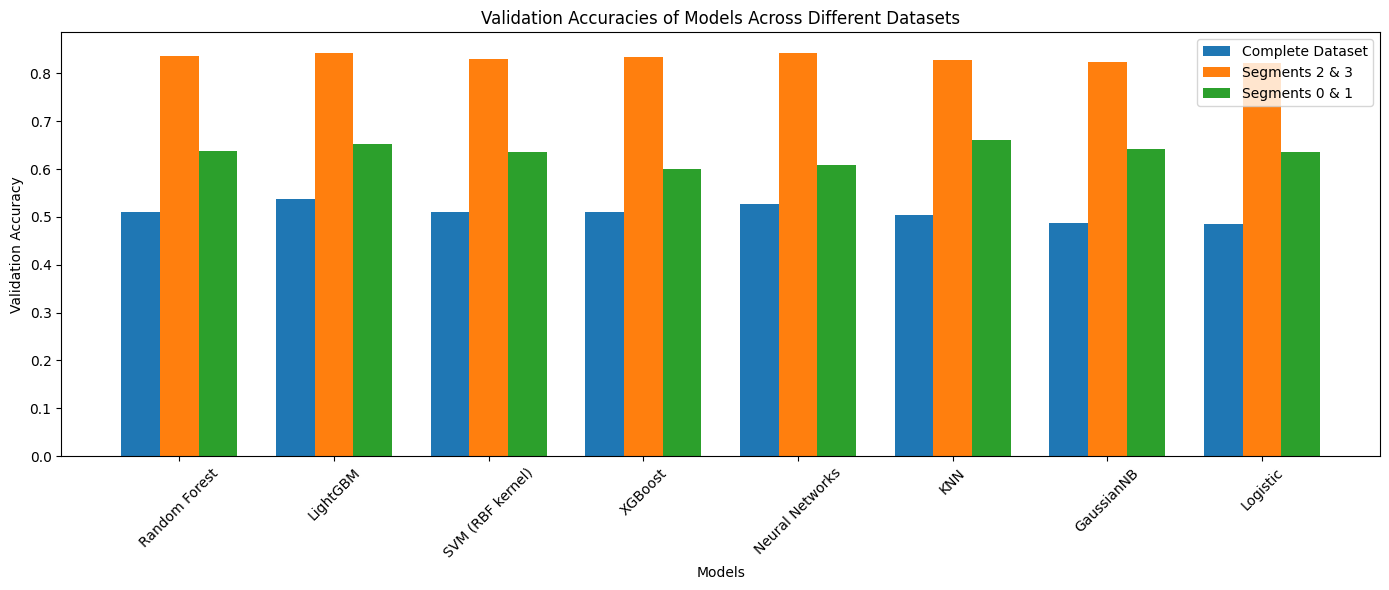

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


models = ['Random Forest', 'LightGBM', 'SVM (RBF kernel)', 'XGBoost', 'Neural Networks', 'KNN', 'GaussianNB', 'Logistic']
complete_dataset = [0.51, 0.5366, 0.5101, 0.5111, 0.5279, 0.5049, 0.488, 0.4851]
segments_2_3 = [0.8372, 0.8436, 0.8301, 0.8349, 0.8431, 0.827, 0.8231, 0.8207]
segments_0_1 = [0.6383, 0.6514, 0.635, 0.60, 0.6083, 0.66, 0.6409, 0.635]

x = np.arange(len(models)) 
width = 0.25 

fig, ax = plt.subplots(figsize=(14, 6))

rects1 = ax.bar(x - width, complete_dataset, width, label='Complete Dataset')
rects2 = ax.bar(x, segments_2_3, width, label='Segments 2 & 3')
rects3 = ax.bar(x + width, segments_0_1, width, label='Segments 0 & 1')

ax.set_xlabel('Models')
ax.set_ylabel('Validation Accuracy')
ax.set_title('Validation Accuracies of Models Across Different Datasets')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
